In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()  # Upload your `kaggle.json` file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"puranjay29","key":"ea40d6e5c237f73605190d36d73c9346"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d emmarex/plantdisease
!unzip -q plantdisease.zip -d plant_disease_data


Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [ ]:
IMG_SIZE = 128
BATCH_SIZE = 32
SEED = 42

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)


In [ ]:
train_generator = datagen.flow_from_directory(
    'plant_disease_data/PlantVillage',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

val_generator = datagen.flow_from_directory(
    'plant_disease_data/PlantVillage',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),  # helps prevent overfitting
    Dense(train_generator.num_classes, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,307,471 (12.62 MB)

 Trainable params: 3,307,023 (12.62 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 95s 183ms/step - accuracy: 0.7771 - loss: 0.6803 - val_accuracy: 0.6897 - val_loss: 1.5214
Epoch 2/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 94s 182ms/step - accuracy: 0.7916 - loss: 0.6428 - val_accuracy: 0.7909 - val_loss: 0.7567
Epoch 3/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 95s 183ms/step - accuracy: 0.7998 - loss: 0.6087 - val_accuracy: 0.5017 - val_loss: 10.4297
Epoch 4/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 95s 183ms/step - accuracy: 0.8032 - loss: 0.6053 - val_accuracy: 0.5803 - val_loss: 3.1825
Epoch 5/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 96s 185ms/step - accuracy: 0.8223 - loss: 0.5639 - val_accuracy: 0.8430 - val_loss: 0.5556
Epoch 6/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 94s 182ms/step - accuracy: 0.8274 - loss: 0.5293 - val_accuracy: 0.5973 - val_loss: 4.1512
Epoch 7/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 96s 185ms/step - accuracy: 0.8386 - loss: 0.5224 - val_accuracy: 0.8896 - val_loss: 0.3999
Epoch 8/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 143s 187ms/step - accuracy: 0.8456 - loss:

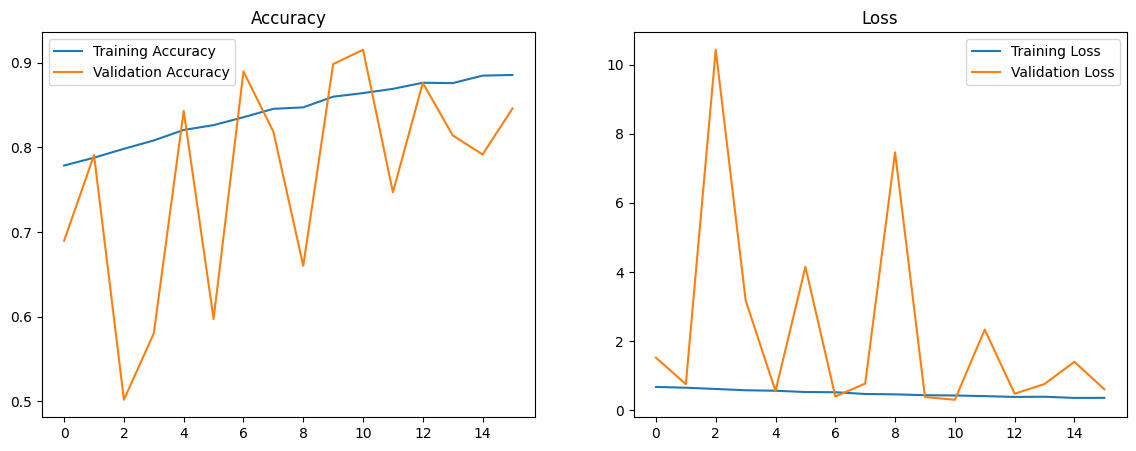

In [ ]:
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)


In [ ]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    class_label = list(train_generator.class_indices.keys())[class_index]

    return class_label


In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload an image (e.g., leaf.jpg)


Saving dis.webp to dis (3).webp


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = list(uploaded.keys())[0]  # Get uploaded file name
img = image.load_img(img_path, target_size=(224, 224))  # Resize to model input
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize


In [ ]:
print("Image shape:", img_array.shape)
model.summary()


Image shape: (1, 224, 224, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,921,519 (37.85 MB)

 Trainable params: 3,307,023 (12.62 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 6,614,048 (25.23 MB)

In [ ]:
from keras.models import load_model

model = load_model('best_model.keras')  # Or whatever file you saved



In [ ]:
img_flat = img_array.reshape(1, -1)  # From (1, 224, 224, 3) → (1, 150528)
print("Flattened image shape:", img_flat.shape)


Flattened image shape: (1, 150528)


In [ ]:
print("Model expects input shape:", model.input_shape)


Model expects input shape: (None, 128, 128, 3)


In [ ]:
from tensorflow.keras.preprocessing import image

img = image.load_img(img_path, target_size=(64, 64))  # Or any size used in training
img_array = image.img_to_array(img) / 255.0
img_flat = img_array.reshape(1, -1)  # Flatten


In [ ]:
from google.colab import files
uploaded = files.upload()



Saving dis.webp to dis (4).webp


In [ ]:
list(uploaded.keys())  # This shows the filename


['dis (4).webp']

In [ ]:
from google.colab import files
uploaded = files.upload()



Saving dis.webp to dis (5).webp


In [ ]:
uploaded.keys()


dict_keys(['dis (5).webp'])

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = 'dis.webp'  # Replace this
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)
confidence = np.max(prediction)

print(f"✅ Predicted Class Index: {predicted_class}")
print(f"📊 Confidence: {confidence * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
✅ Predicted Class Index: 9
📊 Confidence: 100.00%


In [ ]:
print(train_generator.class_indices)


{'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}
